In [1]:
import math
import pandas as pd
import requests
import json
import matplotlib.pyplot as plt
import seaborn as sns

# Scraping the with the Pokemon API

I want to try out scraping data with the Pokemon API and see if I can make a visualization with my data.

Pokemon is a game about exploiting type advantages of your pokemon. Each pokemon type (e.g. grass, fire, water) will take different damage from opposing pokemon's attacks depend on both types (e.g. water deals double damage to fire, and fire deals half damage to water. I will be trying to extract data on pokemon types.

In [2]:
# extract data on each type and store it in a list of dictionaries
type_dicts = []
for i in range(1,19):
    url = ('https://pokeapi.co/api/v2/type/{}/'.format(i))

    response = requests.get(url).json()
    type_dicts.append(response)

In [3]:
# save my data on my computer for later use
with open('types.json', 'w', encoding='utf-8') as f:
  json.dump(type_dicts, f, ensure_ascii=False)

In [4]:
# extract the list of types in the games
type_list = []
for i in range(len(type_dicts)):
    type_list.append(type_dicts[i]['name'])

In [5]:
display(type_list)

['normal',
 'fighting',
 'flying',
 'poison',
 'ground',
 'rock',
 'bug',
 'ghost',
 'steel',
 'fire',
 'water',
 'grass',
 'electric',
 'psychic',
 'ice',
 'dragon',
 'dark',
 'fairy']

There are 18 pokemon types in all, shown here.

## Working with Data

Now that I have extracted the data from the API, I must get it into useable format. I will define 2 methods which will allow me to extract information on how each type interacts with the others while attacking and defending.

In [6]:
# get damage info on when a particular type is defending an attack
def find_dmgfrom(num):
    damage_from = [2]*18
    for i in range(18):
        for j in range(len(type_dicts[num]['damage_relations']['double_damage_from'])):
            if type_dicts[num]['damage_relations']['double_damage_from'][j]['name'] == type_list[i]:
                damage_from[i] = 4
                break
    
        for j in range(len(type_dicts[num]['damage_relations']['half_damage_from'])):
            if type_dicts[num]['damage_relations']['half_damage_from'][j]['name'] == type_list[i]:
                damage_from[i] = 1
                break

        for j in range(len(type_dicts[num]['damage_relations']['no_damage_from'])):
            if type_dicts[num]['damage_relations']['no_damage_from'][j]['name'] == type_list[i]:
                damage_from[i] = 0
                break
    return pd.Series(damage_from, index=type_list)

In [7]:
# get damage info on when a particular type is dealing damage with an attack
def find_dmgto(num):
    damage_to = [2]*18
    for i in range(18):
        for j in range(len(type_dicts[num]['damage_relations']['double_damage_to'])):
            if type_dicts[num]['damage_relations']['double_damage_to'][j]['name'] == type_list[i]:
                damage_to[i] = 4
                break
        
        for j in range(len(type_dicts[num]['damage_relations']['half_damage_to'])):
            if type_dicts[num]['damage_relations']['half_damage_to'][j]['name'] == type_list[i]:
                damage_to[i] = 1
                break
    
        for j in range(len(type_dicts[num]['damage_relations']['no_damage_to'])):
            if type_dicts[num]['damage_relations']['no_damage_to'][j]['name'] == type_list[i]:
                damage_to[i] = 0
                break
    return pd.Series(damage_to, index=type_list)

Now that I have my data in a workable format I will store it in 2 different data frames, one with information on when a type is dealing damage to any type, and another which has information on when a type is recieving damage from any type.

In [8]:
damage_to = pd.DataFrame(index=type_list)
damage_from = pd.DataFrame(index=type_list)

In [9]:
for i in range(len(type_list)):
    damage_to.insert(i, '{}_atk'.format(type_list[i]), find_dmgto(i))
    damage_from.insert(i, '{}_def'.format(type_list[i]), find_dmgfrom(i))

In [10]:
damage_to.head()

,normal_atk,fighting_atk,flying_atk,poison_atk,ground_atk,rock_atk,bug_atk,ghost_atk,steel_atk,fire_atk,water_atk,grass_atk,electric_atk,psychic_atk,ice_atk,dragon_atk,dark_atk,fairy_atk
normal,2,4,2,2,2,2,2,0,2,2,2,2,2,2,2,2,2,2
fighting,2,2,4,2,2,1,1,2,2,2,2,2,2,4,2,2,1,4
flying,2,1,2,2,0,4,1,2,2,2,2,1,4,2,4,2,2,2
poison,2,1,2,1,4,2,1,2,2,2,2,1,2,4,2,2,2,1
ground,2,2,2,1,2,1,2,2,2,2,4,4,0,2,4,2,2,2


In [11]:
damage_from.head()

,normal_def,fighting_def,flying_def,poison_def,ground_def,rock_def,bug_def,ghost_def,steel_def,fire_def,water_def,grass_def,electric_def,psychic_def,ice_def,dragon_def,dark_def,fairy_def
normal,2,2,2,2,2,1,2,0,1,2,2,2,2,2,2,2,2,2
fighting,4,2,1,1,2,4,1,0,4,2,2,2,2,1,4,2,4,1
flying,2,4,2,2,2,1,4,2,1,2,2,4,1,2,2,2,2,2
poison,2,2,2,1,1,1,2,1,0,2,2,4,2,2,2,2,2,4
ground,2,2,0,4,2,4,1,2,4,4,2,1,4,2,2,2,2,2


## Visualizing the Data

Now I will create a visualizulation of how types affect damage calcualtion in pokemon. 

For these graphs, 0 represents a pokemon dealing or taking no damage, 1 represents a pokemon dealing or taking half damage, a 2 represents a pokemon dealing or taking the normal amount of damage, and a 4 represents a pokemon dealing or taking double damage.

The bottom row shows which type is attacking or defending for that paricular graph.

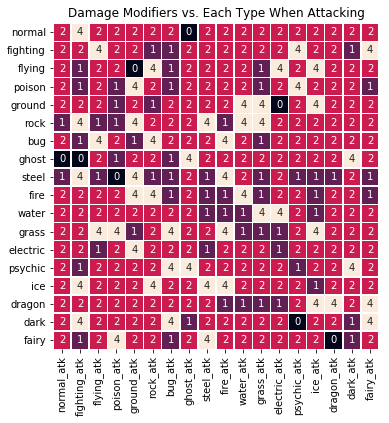

In [12]:
f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(damage_to, annot=True, fmt="d", linewidths=.5, cbar=False, square=True, ax=ax)
plt.title('Damage Modifiers vs. Each Type When Attacking')
plt.show()

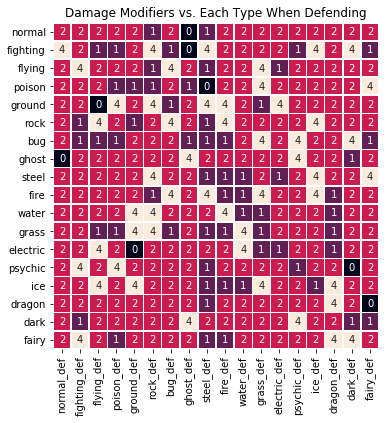

In [13]:
f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(damage_from, annot=True, fmt="d", linewidths=.5, cbar=False, square=True, ax=ax)
plt.title('Damage Modifiers vs. Each Type When Defending')
plt.show()

Success! I was able to extract my data from the API and viusalize it in a workable format.